# Twitter Languagemodel Creator

In [1]:
from fastai.fastai.text import *

import csv
import warnings
warnings.filterwarnings('ignore')

C:\Users\leond\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH = Path("sentiment140/")
BOS = "xbos" #beginning-of-sentence tag
FLD = "xfld" #data field tag

CLAS_PATH = Path("twit_clas_50k/")
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path("twit_lm_50k/")
LM_PATH.mkdir(exist_ok=True)

In [25]:
col_names = ["labels", "text"]

In [26]:
def get_texts(path):
    texts, labels, data = [],[],[]
    
    with open(path, "r") as dataset:
        reader = csv.reader(dataset, delimiter=",")
        data = list(reader)
    dataset.close()
    for turn in data:
        texts.append(turn[5])
        labels.append(turn[0])
    return np.array(texts), np.array(labels)



In [27]:
trn_texts, trn_labels = get_texts(PATH/"train.csv")

ratio = 10


val_texts, val_labels = trn_texts[:int(len(trn_texts)/ratio)], trn_labels[:int(len(trn_labels)/ratio)]
trn_texts, trn_labels = trn_texts[int(len(trn_texts)/ratio):], trn_labels[int(len(trn_labels)/ratio):]

In [28]:
len(trn_texts), len(val_texts)

(1440000, 160000)

In [29]:
trn_texts[:10]

array(['@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[',
       'Layin n bed with a headache  ughhhh...waitin on your call...',
       'Funeral ceremony...gloomy friday... ', 'wants to hang out with friends SOON! ',
       '@dannycastillo We want to trade with someone who has Houston tickets, but no one will. ',
       "Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends ",
       "I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous! ",
       'Hmmm. http://www.djhero.com/ is down ', '@charviray Charlene my love. I miss you ',
       "@kelcouch I'm sorry  at least it's Friday?"], dtype='<U374')

In [30]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

trn_txts = trn_texts[trn_idx]#[int(len(trn_texts)/2.5):] reduce the size
val_txts = val_texts[val_idx]#[int(len(val_texts)/2.5):]

trn_lbls = trn_labels[trn_idx]#[int(len(trn_labels)/2.5):]
val_lbls = val_labels[val_idx]#[int(len(val_labels)/2.5):]

In [31]:
len(trn_txts), len(val_txts)

(1440000, 160000)

In [32]:
df_trn = pd.DataFrame({"text":trn_txts, "labels":[0]*len(trn_txts)}, columns=col_names)
df_val = pd.DataFrame({"text":val_txts, "labels":[0]*len(val_txts)}, columns=col_names)

In [33]:
df_trn.to_csv(LM_PATH/"train.csv", header=False, index=False)
df_val.to_csv(LM_PATH/"valid.csv", header=False, index=False)

In [34]:
df_trn.head()

,labels,text
0,0,@nzdeany I've given up on pizza - kids would n...
1,0,â†’_â†’ Mum works http://bit.ly/zzb8F )
2,0,Here's one for ya: why would unfollowing peopl...
3,0,aww Andrew got his circ. done today and got hi...
4,0,@lisarinna - you are allowed to quit - just ha...


## Tokenization

In [35]:
chunksize = 50000
                 
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += df[i].astype(str)
    texts = list(texts)
    
    for i, tweet in enumerate(texts):
        texts[i] = " ".join([word for word in tweet.split() if not ("www." in word) and not ("http" in word) and not ("@" in word)])
    
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [36]:
def get_all(df, n_lbls=1):
    tok, labels = [],[]
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [37]:
df_trn = pd.read_csv(LM_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/"valid.csv", header=None, chunksize=chunksize)

In [38]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3


In [39]:
(LM_PATH/"tmp").mkdir(exist_ok=True)

In [40]:
np.save(LM_PATH/"tmp"/"tok_trn.npy",tok_trn)
np.save(LM_PATH/"tmp"/"tok_val.npy",tok_val)

In [3]:
tok_trn = np.load(LM_PATH/"tmp"/"tok_trn.npy")
tok_val = np.load(LM_PATH/"tmp"/"tok_val.npy")

In [4]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('i', 886293),
 ('.', 764103),
 ('!', 734647),
 ('to', 500423),
 ('the', 470571),
 (',', 432022),
 ('a', 354775),
 ('t_up', 295250),
 ('you', 281082),
 ('my', 279157),
 ('it', 272026),
 ('and', 271766),
 ('is', 218633),
 ('for', 196164),
 ('?', 193900),
 ('...', 193153),
 ('in', 192490),
 ('of', 164588),
 ("'s", 161362),
 ('that', 157746),
 ('on', 150917),
 ("n't", 149034),
 ('me', 144892),
 ('tk_rep', 143326),
 ('have', 137960)]

In [43]:
len(freq),len([value for value in freq.values() if value > 6])

(321439, 41811)

In [5]:
max_vocab = 50000
min_freq = 6

In [6]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, "_unk_")
itos.insert(1, "_pad_")

In [7]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

41813

In [8]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

np.save(LM_PATH/"tmp"/"trn_ids_50k.npy", trn_lm)
np.save(LM_PATH/"tmp"/"val_ids_50k.npy", val_lm)

pickle.dump(itos, open(LM_PATH/"tmp"/"itos_50k.pkl","wb"))

In [9]:
#necessary
vs = len(itos) #vocabsize
vs, len(trn_lm), len(val_lm)

(41813, 1440000, 160000)

## Wikitext103

In [10]:
em_sz,nh,nl = 400,1150,3
PRE_PATH = PATH/"models"/"wt103"
PRE_LM_PATH = PRE_PATH/"fwd_wt103.h5"

In [11]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [12]:
enc_wgts = to_np(wgts["0.encoder.weight"])
row_m = enc_wgts.mean(0) #mean used for unknown tokens

In [13]:
itos2 = pickle.load((PRE_PATH/"itos_wt103.pkl").open("rb"))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})
len(stoi2)

238462

In [14]:
new_w = np.zeros((vs, em_sz), dtype=np.float32) #0-matrix vocab-size*embedding-size
for i,w in enumerate(itos): #Go through vocab of turn dataset
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m #if word exists copy weight, otherwise average weight

In [15]:
wgts["0.encoder.weight"] = T(new_w)
wgts["0.encoder_with_dropout.embed.weight"] = T(np.copy(new_w))
wgts["1.decoder.weight"] = T(np.copy(new_w))

## Language Model

In [16]:
em_sz, nh, nl = 400,1150,3

bptt=70
bs=60 #biggest batch size possible for quicker learning - Figure 6 https://arxiv.org/pdf/1803.09820.pdf
wd=1e-6 #https://arxiv.org/pdf/1803.09820.pdf - smaller wd for large learning rates for super convergence Figure 5 b)
# Smaller datasets and architectures seem to require larger values for weight decay while larger datasets and
# deeper architectures seem to require smaller values. Our hypothesis is that complex data provides
# its own regularization and other regularization should be reduced.
opt_fn = partial(optim.SGD, momentum=0.9)

In [17]:
trn_lm = np.load(LM_PATH/"tmp"/"trn_ids_50k.npy")
val_lm = np.load(LM_PATH/"tmp"/"val_ids_50k.npy")
itos = pickle.load(open(LM_PATH/"tmp"/"itos_50k.pkl","rb"))

vs = len(itos)
vs, len(trn_lm)

(41813, 1440000)

In [18]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [19]:
md.trn_dl.data = md.trn_dl.data.long()
md.val_dl.data = md.val_dl.data.long()

In [20]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15], dtype="f")*0.1

In [21]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
                      dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip= 0.12
learner.unfreeze()
learner.get_layer_groups()

[(WeightDrop(
    (module): LSTM(400, 1150)
  ), LockedDropout()), (WeightDrop(
    (module): LSTM(1150, 1150)
  ), LockedDropout()), (WeightDrop(
    (module): LSTM(1150, 400)
  ), LockedDropout()), (LinearDecoder(
    (decoder): Linear(in_features=400, out_features=41813, bias=False)
    (dropout): LockedDropout()
  ), LockedDropout())]

In [22]:
learner.model.load_state_dict(wgts)

  9%|██████▎                                                             | 500/5355 [02:34<25:59,  3.11it/s, loss=5.42]

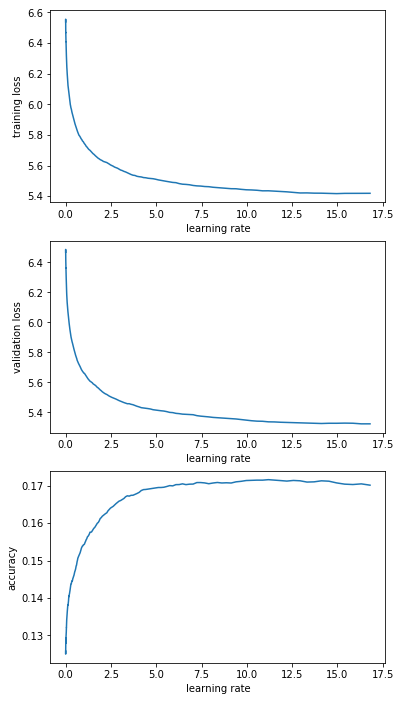

In [62]:
learner.lr_find2(num_it=500, end_lr=20)
learner.sched.plot()

In [64]:
lr = 12.5

In [65]:
learner.fit(lr, 1,use_clr_beta=(10,10,0.95,0.85), cycle_len=10, best_save_name="best_lm_wt103")

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.639711   4.561567   0.226325  
    1      4.527058   4.497019   0.231032                                                                              
    2      4.470577   4.477754   0.232834                                                                              
    3      4.429457   4.477559   0.232772                                                                              
    4      4.427572   4.460913   0.233575                                                                              
    5      4.358075   4.453086   0.235236                                                                              
    6      4.323382   4.434605   0.237057                                                                              
    7      4.254107   4.426396   0.238738                                                                           

[4.396886806114657, 0.24453900635339695]

(None, None)

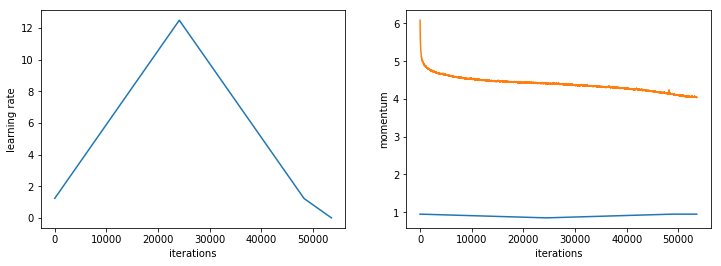

In [66]:
learner.sched.plot_lr(), learner.sched.plot_loss()

In [67]:
learner.save("lm0_fit_wt103_based")
learner.save_cycle("lm0_fit_wt103_based_cyc", 5)
learner.save_encoder("lm0_fit_wt103_based_enc")


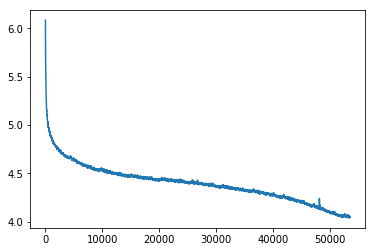

In [68]:
learner.sched.plot_loss()

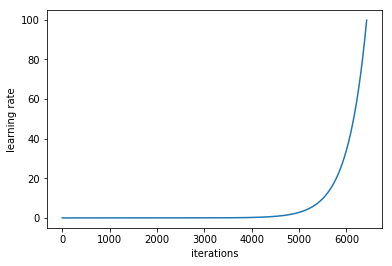

In [47]:
learner.sched.plot_lr()

In [69]:
np.exp(4.05)

57.39745704544619

## Evaluate 

In [26]:
#from https://github.com/cedrickchee/data-science-notebooks/blob/master/notebooks/deep_learning/ULMFiT/malay_language_model.ipynb

In [70]:
m = learner.model # initialized model
m.eval() # ensure you switch your model to inference mode
m[0].bs = 1 # set batch size to 1

In [71]:
# Load the index-word mapping from the picked file on disk to help us convert the indexes to words.
itos = pickle.load(open(LM_PATH / "tmp" / "itos.pkl", "rb"))

# String to index lambda function
stoi = collections.defaultdict(lambda: 0, {v:k for k, v in enumerate(itos)})
len(itos)

50002

In [77]:
# Utility functions
from random import randint

def gen_text(ss, topk):
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]

    return [itos[o] for o in to_np(pred_i)]

def generate_sentences(ss, nb_words):
    result = []
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    
    #for i in range(nb_words):
    word = ""
    while (word != "." and word !="..."):
        pred_i = pred[-1].topk(3)[1]
        idx = randint(1,len(pred_i)-1)
        pred_i = pred_i[idx] #if pred_i.data[0] < 1 else pred_i[1]
        if pred_i.data[0] != 0:
            word = itos[pred_i.data[0]]
            result.append(word)
            pred, *_ = m((pred_i[0].unsqueeze(0).expand(1,2)))
    
    result = re.sub('\s+([.,])', r'\1', "{} {}".format(ss, " ".join(result).rstrip()))

    return(result)

In [23]:
strings = [
    "I'm not racist, but",
    "The average black",
    "Normally",
    "My grandpa",
    "OMG",
    "I love"
]

In [24]:
for s in strings:
    print(f"{s}... \n{generate_sentences(s.lower(), 25)}\n")

NameError: name 'generate_sentences' is not defined

In [23]:
math.exp(4.05)

57.39745704544619